# Clusterers for Toponymy

Toponymy supports different ways to cluster your data. There is a default approach, the ``ToponymyClusterer`` that works well with the rest of the toolchain. However other clusterers exist, and it can be relatively easy to create your own clusterer that can plug directly into the existing Toponymy infrastructure. This tutorial will look at the clusterers available, and briefly explore what would be involved in writing your own clusterer class that can work with Toponymy.

Before we start let's get some basic librarties imported, and load some data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We'll use the standard 20-newsgroup data with pre-built embeddings and a pre-built data map.

In [2]:
newsgroups_df = pd.read_parquet("hf://datasets/lmcinnes/20newsgroups_embedded/data/train-00000-of-00001.parquet")

In [3]:
newsgroups_df.head()

,post,newsgroup,embedding,map
0,\n\nI am sure some bashers of Pens fans are pr...,rec.sport.hockey,"[-0.04380008950829506, 0.08495834469795227, -0...","[-0.13199903070926666, 10.1972017288208]"
1,My brother is in the market for a high-perform...,comp.sys.ibm.pc.hardware,"[0.006855607498437166, -0.05531690642237663, -...","[11.03041934967041, 9.509867668151855]"
2,\n\n\n\n\tFinally you said what you dream abou...,talk.politics.mideast,"[0.01537406351417303, 0.03572937101125717, -0....","[1.7360589504241943, -0.31686803698539734]"
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,comp.sys.ibm.pc.hardware,"[0.010156078264117241, -0.07253803312778473, -...","[10.975887298583984, 10.715202331542969]"
4,1) I have an old Jasmine drive which I cann...,comp.sys.mac.hardware,"[-0.008448092266917229, 0.06011670082807541, 0...","[10.498811721801758, 11.010639190673828]"


For the purposes of the clusterer we really care about two things -- the embedding vectors, and a potentially different representation that is ideally more clusterable than the raw embedding vectors (usually via some manner of dimension reduction). 

In [4]:
document_vectors = np.stack(newsgroups_df["embedding"].values)
clusterable_vectors = np.stack(newsgroups_df["map"].values)

We can import the different clusterers directly from ``toponymy.clustering``. We'll import the default ``ToponymyClusterer`` as well as the ``KMeansClusterer`` and the ``EVoCClusterer``. To make use of the clusterer's ``fit`` method we will also need a layer class since the clusterer will create the relevant cluster layers with the given class. For this demonstration we just have text so the basic ``ClusterLayerText`` well be fine here.

In [5]:
from toponymy.clustering import ToponymyClusterer, KMeansClusterer, EVoCClusterer
from toponymy.cluster_layer import ClusterLayerText

## ToponymyClusterer

We'll start with the ``ToponymyClusterer``. It is designed to work well within the Toponymy framework, and to be easy to use without having to worry too much about complicated hyperparameter choices. The default choices for the ToponymyClusterer should work reasonably well for most datasets. However, lets set some of the major options here to demonstrate what can be altered.

The ToponymyClusterer uses a variant of HDBSCAN, but produces a number of layers at different clustering rsolutions rather than a hierarchical tree of clusters. This provides a less complex structure to work with (a short list of layers) and ensures that each layer has clusters of roughly the same size, resulting in layers of topics that will be on roughly the same scale of specificity/generality. To control this we can set ``base_n_clusters`` which determines (roughly) how many clusters to aim for at the most fine-grained resolution, and ``min_clusters`` which gives the minimum number of clusters to accept at uppermost clustering layer that contains the fewest clusters. If you would rather determine the *size* of clusters at the finest scale ``base_min_cluster_size`` can be specified instead. The ``next_cluster_size_quantile`` controls the qualtile of cluster sizes used to determine the ``min_cluster_size`` for the next layer. From a practical perspective you should think of this as a value on 1.0 specifying that there should be as few layers as possible, and lower values resulting in more layers of clusters (up to infintiely many layers for a value of 0.0 -- we don't recommend doing this).

Since we have an HDBSCAN-like algorithm a ``min_samples`` value can also be specified -- see [HDBSCAN documentation](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html) for more details on that parameter.

Lastly we'll set ``verbose`` to ``True`` so we can see progress information as the model is fit.

In [6]:
clusterer = ToponymyClusterer(
    min_clusters=6,
    base_n_clusters=512,
    next_cluster_size_quantile=0.95,
    min_samples=3,
    verbose=True,
)

Next we need for fit the model. For this we need a few things: 
 * ``clusterable_vectors`` which should be a vector representation of your objects (in this case text samples) that is clusterable via a clustering algorithm like HDBSCAN. In practice that means a low-dimensional representation. If you are wanting to visualize your data this can often be a 2D representation from UMAP, t-SNE, or other similar algorithms. If visualization isn't required then some other representation, ideally in the 2 to 50 dimensional range, provided by, say, UMAP, should be sufficient. We keep this separate so that you can choose whichever dimension reduction method you wish.
 * ``embedding_vectors`` which should be a potentially high dimensional (dense) vector representation of your objects. Usually this would be the outpuyt of a neural embedding model. In the case of text working with [sentence-transformers]() package would be a good approach. You could even use classical NLP methods like ``CountVectorizer`` or ``TfidfVectorizer`` from scikit-learn, but you will need to use a TruncatedSVD to get those sparse vectors down to dense vectors for use here.
 * Optionally a ``layer_class`` which will provide appropriate tools for dealing with different object types. The default is ``ClusterLayerText`` which is suitable for short to medium length text samples (and so we don't actually have to specify it here, but we will for completeness). Other options include classes for working with images ``ClusterLayerImage``, long documents ``ClusterLayerLongText``, etc. Not all of these have been implemented yet, but should be coming.

Given these things we can simply pass them all to the clusterer's ``fit`` method to train the model.

In [7]:
clusterer.fit(
    clusterable_vectors=clusterable_vectors, 
    embedding_vectors=document_vectors, 
    layer_class=ClusterLayerText
)

Layer 0 found 511 clusters
Layer 1 found 110 clusters
Layer 2 found 21 clusters
Layer 3 found 6 clusters


The verbose output tells us about the various layers of clustering that have been generated, and the numbers of clusters found at each layer. Note that at the base layer we did not find exactly the 512 clusters we specified, but rather the closest value the clusterer could find, in this case 511. As we cluster higher layers we get fewer clusters until we reach the ``min_clusters`` threshold and stop. In this case we have generated four layers. We can access the layers themselves via the ``cluster_layers_`` attribute which provides a list of ``ClusterLayerText`` objects:

In [8]:
clusterer.cluster_layers_

We also have a cluster tree, which provides the relative nesting tree structure of the clusters we have found. This is accessible as the ``cluster_tree_`` attribute, which as we see below, is a dictionary:

In [9]:
type(clusterer.cluster_tree_)

dict

The dictionary is keyed by numeric tuples of ``(layer_num, cluster_num)`` with values being the list of ``(layer_num, cluster_num)`` tuples that are the child clusters of the given cluster. For example, to find the immediate children of the zeroth cluster in the uppermost layer we provide the key ``(3, 0)``:

In [10]:
clusterer.cluster_tree_[(3,0)]

[(2, 1), (2, 0), (1, 0), (0, 0)]

If you want to access the actual cluster labels for a given cluster layer you can get that via the ``cluster_labels`` attribute of a given ``ClusterLayer``. For example, to get cluster labels for the base layer of our clustering we can tyr the following:

In [11]:
clusterer.cluster_layers_[0].cluster_labels

array([ -1, 475,  -1, ..., 148, 422,  -1])

The result is a scikit-learn style label vector wityh a numeric value for example sample clusters. Negative labels represent noise points, and positive labels provide the cluster index that a given sample belongs to.

To get some sense of how the clustering has worked over the various layers let's create a simple plotting function that can plot a scatterplot of our ``clusterable_vectors`` coloured by cluster. Since we'll be reusing this we will make it a little flexible: it should handle a variable number of layers, plotting the result in a small grid; and we want to discern clusters, so let's shuffle the cluster indices (since the clusterer tends to give nearby clusters similar cluster indices).

In [12]:
def plot_cluster_layers(cluster_layers):
    fig, axs = plt.subplots(2, 2, figsize=(8,8))
    for i, layer in enumerate(cluster_layers):
        max_clusters_ind = layer.cluster_labels.max()
        cluster_shuffle = np.arange(max_clusters_ind + 1)
        np.random.shuffle(cluster_shuffle)
        color_mapping = [plt.cm.Spectral(cluster_shuffle[x] / max_clusters_ind) if x >= 0 else (0.66, 0.66, 0.66, 0.5) for x in layer.cluster_labels]
        axs[i // 2, i % 2].scatter(*clusterable_vectors.T, s=0.1, c=color_mapping, alpha=0.25)
        axs[i // 2, i % 2].set_title(f"Layer {i} clusters")
        axs[i // 2, i % 2].axis('off');

Now let's plot the resulting clustering, providing the various layers in different subplots:

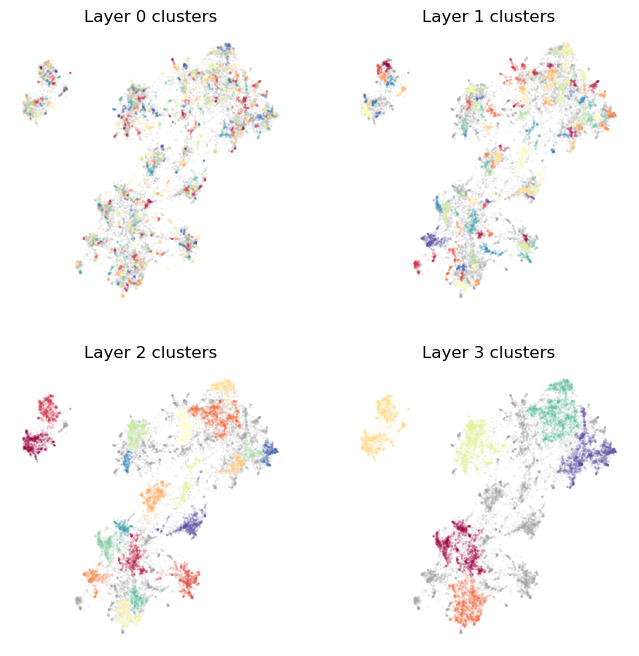

In [13]:
plot_cluster_layers(clusterer.cluster_layers_)

As you can see, the bottommost layer 0 captures very fine grained topics, with much of the data falling on one small cluster or another. As we move up the layers we capture larger and larger scale structures and more general topics. Notably we also fine more data cast aside as noise. This reflects topics that are specific, but not part of the larger scale topics in the data. Working this way we have the uppermost layer providing the major themes of the corpus, with those themes not being polluted by smaller unrelated topics. At the same time, the top level also doesn't include those smaller scale topics as separate clusters -- they aren't large enough to appear at that uppermost level. The smaller topics do appear, however, as we move down through the layers, allowing a finer topic resolution, and thus picking up smaller scale topics for consideration. This layered structure is used heavily within Toponymy to help provide good topic names for the large scale topics (for which we cannot reasonably sample adequately from the large number of documents within the topic).

## EVōC Clusterer

It is not always the case that you are interested in a visualizable representation of the corpus, and just want to get to clusters without having to produce your own clusterable representation, without any particular preferences on any dimension reduction that may occur along the way. If that's the case you likely also want to get clusters out as quickly as possible. For that we provide the ``EVoCClusterer`` which makes use of [EVōC](https://github.com/TutteInstitute/evoc) a library for very efficient **E**mbedding **V**ector **O**riented **C**lustering. The ``EVoCClusterer`` clusterer works very similarly to ``ToponymyClusterer``, with similar hyper-parameter arguments. Much like the ``ToponymyClusterer`` we have the ability to specify the ``base_min_cluster_size`` or, alternatively, the ``base_n_clusters``. Also like ``ToponymyClusterer`` there is a ``next_cluster_size_quantile`` and ``min_clusters`` that determine the number of layers produced. Other parameters are more specific to EVōC, so check the documentation for further details.

In [17]:
clusterer = EVoCClusterer(
    min_clusters=6,
    min_samples=3,
    base_n_clusters=512,
    next_cluster_size_quantile=0.9,
)

One difference is that, when it comes time for fit the clusterer model, there is no need to pass in clusterable vectors. To keep API compatibility it is still an argument to ``fit``, but you can pass in the high dimensional vectors (and pass the same vectors as ``embedding_vectors``). EVōC will take care of ensuring the high dimensional data is clustered.

In [18]:
clusterer.fit(
    clusterable_vectors=document_vectors, 
    embedding_vectors=document_vectors, 
    layer_class=ClusterLayerText
)

Again we can visualize the results. You'll see that they are qualitatively similar to what we got from the ``ToponymyClusterer``, but not indentical. In particular the clusters needn't follow precisely from the low dimensional layout used for visualization, and may be slightly disconnected in the visual representation since it needn't be exactly aligned to that particular dimension reduction outcome. Another thing to note is that EVōC is fast -- much faster than applying stdnard dimension reduction and clustering the result. Lastly it is important to note that EVōC is trading reproducibility for that speed: different runs are not guranteed to produce identical results.

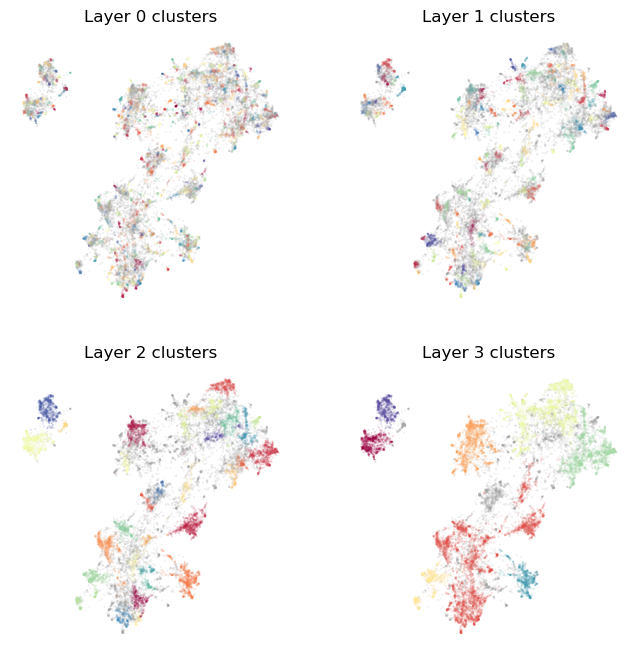

In [19]:
plot_cluster_layers(clusterer.cluster_layers_)

## Your Own Clusterer

It is not that hard to write your own clusterer for Toponymy that wraps your preferred clustering solution. Toponymy provides a ``Clusterer`` base class to inherit from (``toponymy.clustering.Clusterer``), and it is not hard to follow the required patterns to get a Clusterer up and running. To make this a little easier we provide a very simple demonstration clusterer, the ``KMeansClusterer`` which produces multiple layers using the K-Means clustering algorithm. We can instantiate one easily enough:

In [20]:
clusterer = KMeansClusterer(
    min_clusters=6,
    base_n_clusters=512,
)

To see how it works, let's query the object for its source code:

In [23]:
clusterer??

Type:        KMeansClusterer
String form: <toponymy.clustering.KMeansClusterer object at 0x7f72c366b050>
File:        ~/src/topicnaming/toponymy/clustering.py
Source:     
class KMeansClusterer(Clusterer):
    """
    A class for clustering data in layers using KMeans. This class is mostly to demonstrate how one might write
    an alternative Clusterer to the ToponymyClusterer (which uses a variation of HDBCSCAN). We recommend using the
    ToponymyClusterer in practice.

    Parameters
    ----------
    min_clusters : int, optional
        The minimum number of clusters to form in a layer (default is 6).
    base_n_clusters : int, optional
        The initial number of clusters for the most fine-grained cluster layer (default is 1024).

    Attributes
    ----------
    cluster_layers_ : List[ClusterLayer]
        A list of the created cluster layers.
    cluster_tree_ : Dict[Tuple[int, int], List[Tuple[int, int]]]
        A dictionary representing the cluster tree. Keys are a tuple 

As you can see, there is not a lot to this. We need to provide an ``__init__`` method (calling the base class ``__init__``) to get out parameters set, and then a ``fit`` method, and a ``fit_predict`` method. The ``fit_predict`` method is also easy -- just call fit, and return a list of cluster layers and a cluster tree. All the complexity (what little of it there is) lies in the ``fit`` method. We need to to generate multiple layers of clusterign at different resolutions. How to determine resolutions is up to you. For the example KMeans clusterer we start with aa base number of custers and use the previous number of clusters divided by four for the next layer and so on. Having built all the layers we also need to generate a tree. We can do that via the existing function ``toponymy.clustering.build_cluster_tree`` that will do the job (it is designed to work with the ToponymyClusterer that ensures more tree like-structure over layers, but it will wuffice in this case). Lastly we need to create a list of layers instatiated according to the ``layer_class`` that was passed in. This follows a standard pattern that you can just follow.

Having built a new clusterer, let's try it out:

In [15]:
clusterer.fit(
    clusterable_vectors=clusterable_vectors, 
    embedding_vectors=document_vectors, 
    layer_class=ClusterLayerText
)

We can use the existing plotting routine to view the results:

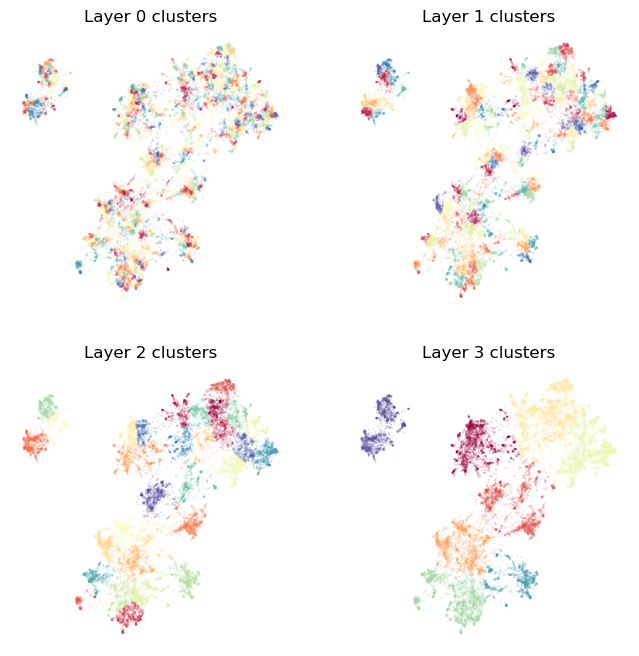

In [16]:
plot_cluster_layers(clusterer.cluster_layers_)

Alternatively we can pass in the high dimensional vectors and let KMeans try to work there. This will not be ideal for labelling the map, but it will work:

In [21]:
clusterer.fit(
    clusterable_vectors=document_vectors, 
    embedding_vectors=document_vectors, 
    layer_class=ClusterLayerText
)

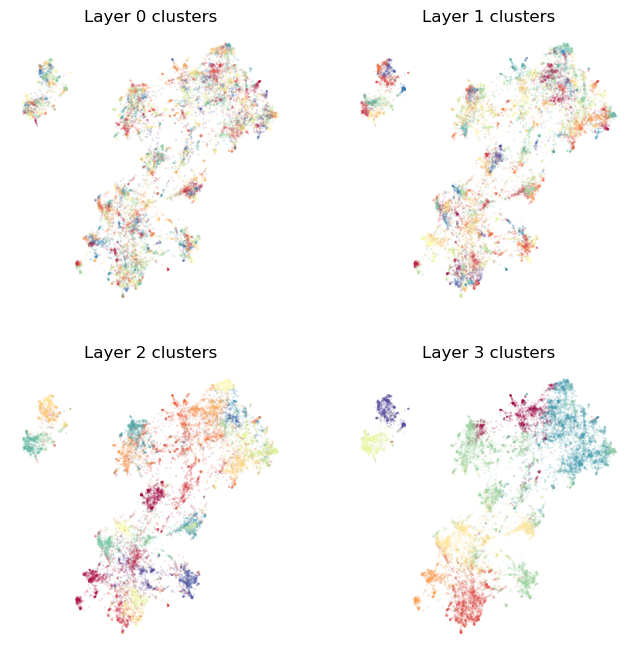

In [22]:
plot_cluster_layers(clusterer.cluster_layers_)

Hopefully this gets you started on working withy clusterers in Toponymy. For more information you can consult the Clustering options tutorial, which goes into more detail about the various options and hyper-parameters available in the ToponymyClusterer.